In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

### Opening predator-prey dataset

In [2]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()

,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


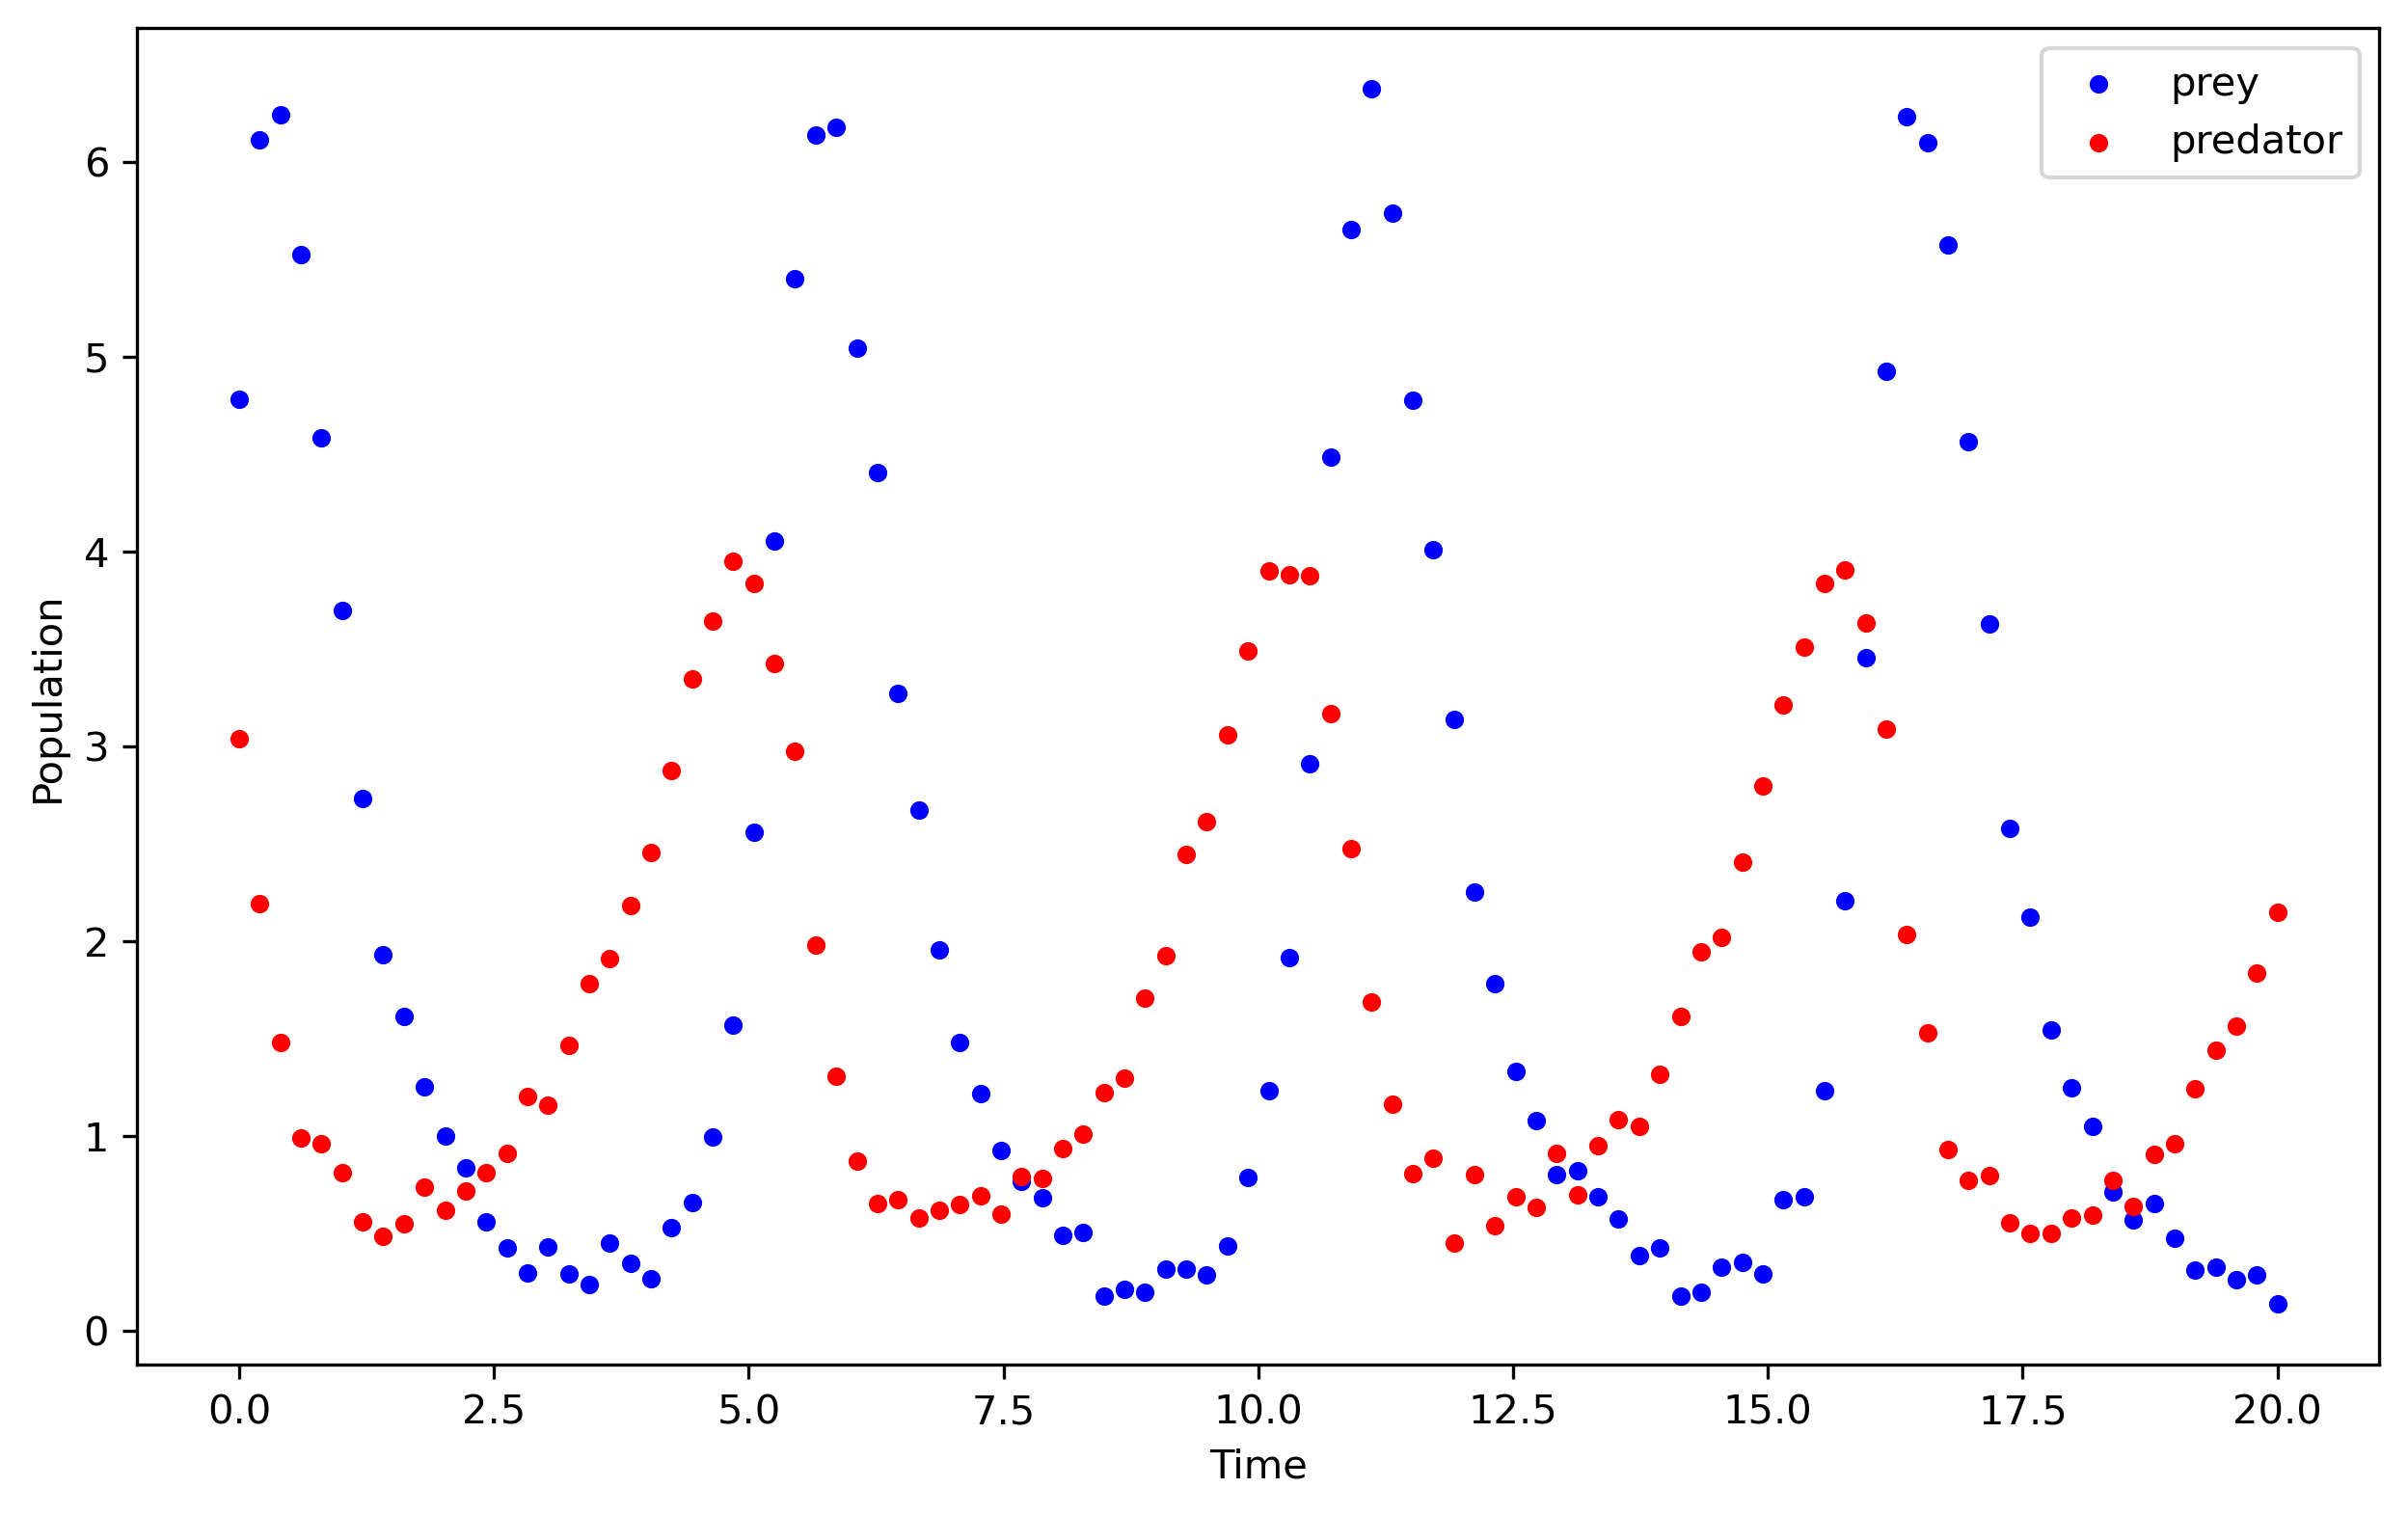

In [3]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values
# data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False


# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
plt.scatter(data[:,0], data[:,1], label = 'prey', color = 'blue', s =point_width)
plt.scatter(data[:,0], data[:,2], label = 'predator', color = 'red', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()


### Objective functions

#### Defining volterra equations function

In [4]:
def predator_prey_odes(initial_conditions,time ,alpha, beta, delta, gamma):
    x = initial_conditions[0]  # initial predator population
    y = initial_conditions[1]  # initial prey population
    dxdt = (alpha * x) - (beta * x * y)  # Prey ODE
    dydt = (delta * x * y) - (gamma * y)  # Predator ODE
    return [dxdt, dydt]


In [5]:
#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_integration(time,initial_conditions,parameters): 
    alpha,beta,delta,gamma = parameters
    results = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    predator_values,prey_values = results[:,0], results[:,1]
    return np.array([predator_values,prey_values]).T



### Defining objective functions

In [101]:
def weighted_sse(actual, predicted):
    '''Weighted sum of squared erros'''

    sd = 0.01

    sd_list = sd*actual #List of estimated standard deviations
        
    inv_sd = 1/sd_list #List of inverted standard deviations from sd_list
        
    weighted_sse =  np.sum(sd_list*((actual - predicted)**2))

    #weighted_sse = 

    return weighted_sse


def MAE(actual, predicted):
    '''Mean absolute error'''
    return np.mean(np.abs(actual - predicted))



def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

In [7]:
test = np.array([1,2,3])

mult = 3*test
print(mult)

sum = np.sum(mult*test)

print(sum)

[3 6 9]
42


### Algorithms & Optimisation

#### Simulated Annealing

In [8]:
def random_walk_annealing(parameters): #A random walk designed for annealing algorithm
    lst = [parameter + np.random.normal(0, 0.5) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <= 0:
                lst[indx] = max(0, parameters[indx] + np.random.normal(0, 0.5)) #Walk is scaled by scale, which depends on the temperature in the annealing algorithm

    return lst



def simulated_annealing(initial_temp,cooling_constant, data, time, initial_conditions, parameters, objective, max_iterations):

    temp = initial_temp #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases
    start = parameters #Initial starting parameters
    x_n = start
    scores = [] #A score is just the value of the objective function evaluated at a certain point.

    current_est = predator_prey_integration(time, initial_conditions, x_n) #Outputs the data points of the predator prey function for the current set of parameters
    current_score = objective(data, current_est) #The current value of the objective function (which is determined by the actual data and the current estimate)
    scores.append(current_score) #Keeping track of the values of the objective function

    #cur = function(x) #The function value of the current x solution
    history = [x_n] #Stores previously searched x values

    for i in range (max_iterations):

        proposal = random_walk_annealing(x_n) #A new proposal for the parameters is generated by taking a random walk scaled by the scale
        new_est = predator_prey_integration(time, initial_conditions, proposal) #Calculate new function values based on proposal parameters
        new_score = objective(data, new_est) #Calculate new value of objective function based on new function values

        delta = new_score - current_score #Difference in objective function values

        #if proposal < 0 or proposal > 1:
           #proposal = x_n # Reject proposal by setting it equal to previous x_n if it is not in the correct range
    
        acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability

        #if delta < 0:
           #x_n = proposal ##Accept proposal
            #current_score = new_score

        if np.random.rand() < acceptance_probability: #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x_n = proposal #Accept proposal
            current_score = new_score

        scores.append(current_score)
        temp = cooling_constant**i * initial_temp #Cool temperature
        #print(temp)
        history.append(x_n) #Add to history
    
    return x_n, scores

In [90]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]

#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
initial_temp = 20
cooling_constant = 0.10

# Using MSE
x_best, scores = simulated_annealing(initial_temp,cooling_constant, input_data, t, input_data[0], parameters, MSE, max_iterations=5000)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


In [184]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]

#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
initial_temp = 20
cooling_constant = 0.10

# Using MSE
x_best, scores = simulated_annealing(initial_temp,cooling_constant, input_data, t, input_data[0], parameters, MAE, max_iterations=5000)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


#### Solution discovery over iterations

LOWEST MSE: 1.3145243092280952


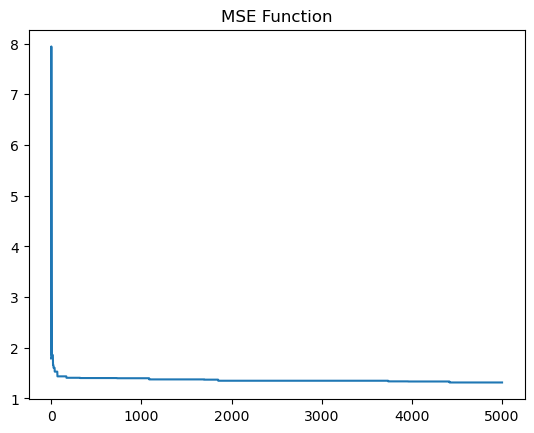

In [185]:
xvalues = [x for x in range(0,len(scores))]



plt.plot(xvalues,scores)
plt.title("MSE Function")

print("LOWEST MSE: " + str(scores[-1]))

### Curve fit

MAE: 1.3145243092280952


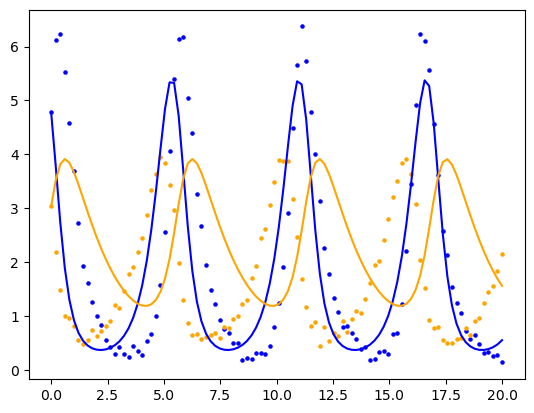

In [186]:
# t, x ,y = data
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
scaling = 2

parameters = x_best

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)

#plt.figure(dpi =300, figsize=(6, 5))
point_width = 13
plt.plot(t, x[:,0],color = "b")
plt.plot(t, x[:,1],color = "orange")

plt.scatter(t, data[:,1], color= 'blue', s = 5)
plt.scatter(t, data[:,2], color= 'orange', s = 5)

#mse_prey = MSE(data[:,1],x[:,0]) #MSE for fitted curve
#mse_predator = MSE(data[:,2],x[:,1])
#mse_total = mse_prey + mse_predator
print("MAE: " +str(scores[-1]))

#### Calculation of mean and variance

In [96]:
### Distribution of parameters for multiple runs

def multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,objective_function,n_runs): #Runs the annlealing algorithm miltiple times and returns the a list of MSE for each simulation

    mse_total_list = []
    
    
    for i in range(n_runs):
        
        x_best, scores = simulated_annealing(initial_temp,cooling_constant, input_data, t, input_data[0], parameters, objective_function, max_iterations=5000)
        
        mse = scores[-1]
    
        mse_total_list.append(mse) #Add total MSE for this simulation to the MSE list
        
    return mse_total_list


In [106]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
parameters = [alpha, beta, delta, gamma]

initial_temp = 20
cooling_constant = 0.10

mse_total_list = multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,MSE,10)

#print(mse_total_list)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_58892/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_58892/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_58892/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/Users/alex_1/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [107]:
print(mse_total_list)

[2.6473227546360665, 2.7464957827676564, 2.8201901313461293, 2.684807252548282, 2.6589224841462658, 2.5022908556330266, 2.4583578426621084, 2.4390199669793287, 2.460643513633285, 2.543829159819853]


In [108]:

mean_mse_annealing = np.mean(mse_total_list)
std_mse_annealing = np.std(mse_total_list)

print("Average MSE = " + str(mean_mse_annealing))
print("Standard deviation of MSE = " + str(std_mse_annealing))

Average MSE = 2.5961879744172007
Standard deviation of MSE = 0.12680792857239243


### FOR WEIGHTED SSE

In [189]:


input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
parameters = [alpha, beta, delta, gamma]

initial_temp = 20
cooling_constant = 0.10

mse_total_list = multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,MAE,10)


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


In [190]:
print(mse_total_list)
print(np.std(mse_total_list))

[1.4283946885408745, 1.3067741402910857, 1.4442398586927112, 1.2894009205471197, 1.4204590248705167, 1.4440930616053458, 1.3031423818937582, 1.3589696758657763, 1.3465599587990993, 1.3043258816810026]
0.06051240976134452


### Comparison of cooling schedules

In [221]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
parameters = [alpha, beta, delta, gamma]

initial_temp = 20

cooling_constants = np.arange(0.10,1,0.10)

mean_mse_per_simulation = [] #The mean MSE per simulation
sd_mse_per_simulation = [] #The standard deviation per simulation

for constant in cooling_constants:

    mse_total_list = multiple_runs_annealing(initial_temp,constant,input_data,t,parameters,MSE,10)
    mean_mse_annealing = np.mean(mse_total_list)
    std_mse_annealing = np.std(mse_total_list)
    mean_mse_per_simulation.append(mean_mse_annealing)
    sd_mse_per_simulation.append(std_mse_annealing)



/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/Users/alex_1/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


In [222]:
mean_mae_per_simulation = []
sd_mae_per_simulation = []

for constant in cooling_constants:

    mae_total_list = multiple_runs_annealing(initial_temp,constant,input_data,t,parameters,MAE,10)
    mean_mae_annealing = np.mean(mae_total_list)
    std_mae_annealing = np.std(mae_total_list)
    mean_mae_per_simulation.append(mean_mae_annealing)
    sd_mae_per_simulation.append(std_mae_annealing)


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


Text(0.5, 1.0, 'Average MAE for different cooling schedules')

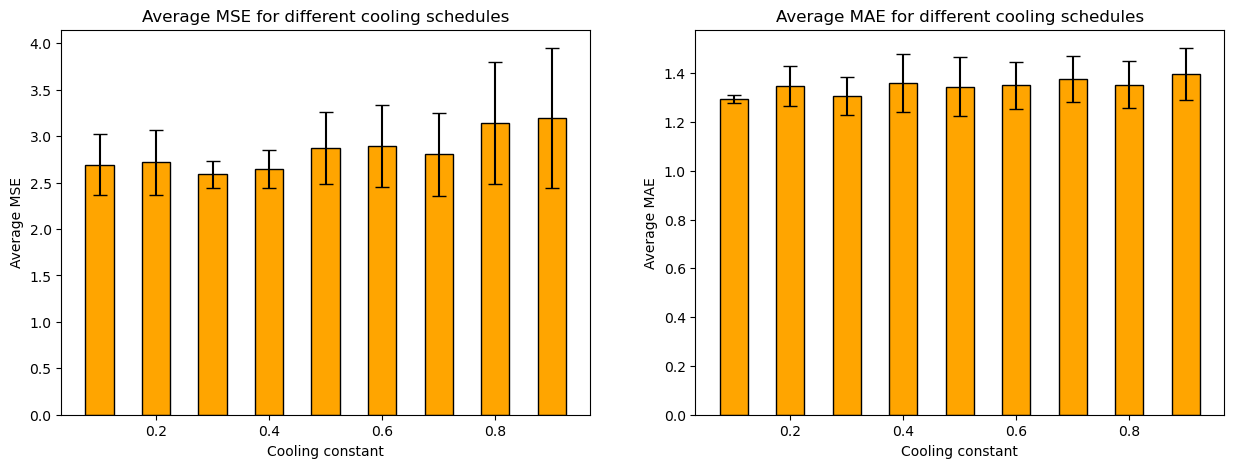

In [223]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

bar_width = 0.05

axes[0].bar(cooling_constants, mean_mse_per_simulation, yerr = sd_mse_per_simulation,color = "orange",ec = "black", ecolor = "black",capsize = 5,width= bar_width)
axes[1].bar(cooling_constants, mean_mae_per_simulation, yerr = sd_mae_per_simulation,color = "orange",ec = "black", ecolor = "black",capsize = 5,width= bar_width)

axes[0].set_xlabel("Cooling constant")
axes[1].set_xlabel("Cooling constant")

axes[0].set_ylabel("Average MSE")
axes[1].set_ylabel("Average MAE")

axes[0].set_title("Average MSE for different cooling schedules")
axes[1].set_title("Average MAE for different cooling schedules")



#plt.bar(cooling_constants, mean_per_simulation, yerr = sd_per_simulation,color = "orange",ec = "black", ecolor = "black",capsize = 5,width= bar_width)
#plt.ylabel("Average MSE")
#plt.xlabel("Cooling constant")
#plt.title("Average MSE for different cooling schedules (30 simulations per schedule)")

#plt.show()


### Hill climbing

In [238]:


def random_walk(parameters):
    lst = [parameter + np.random.normal(0, 0.5) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <= 0:
                lst[indx] = max(0, parameters[indx] + np.random.normal(0, 0.5))

    return lst

def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)

    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores


In [239]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]

# Using MSE
x_best,scores = hill_climbing(input_data, t, input_data[0], parameters, MSE, max_iterations=5000)

### Curve fit

Mean Square Error: 5.385424572357688


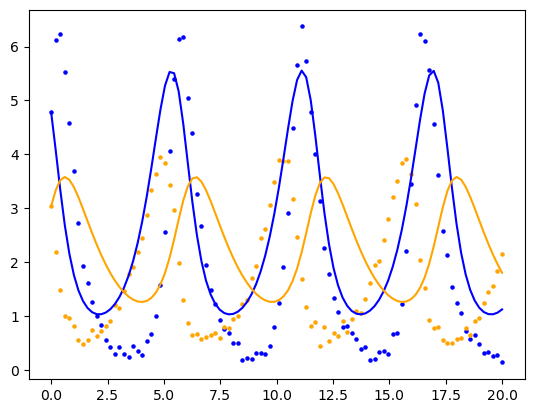

In [241]:
# t, x ,y = data
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]

parameters = x_best

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)



point_width = 13
plt.plot(t, x[:,0],color = "b")
plt.plot(t, x[:,1],color = "orange")

plt.scatter(t, data[:,1], color= 'blue', s = 5)
plt.scatter(t, data[:,2], color= 'orange', s = 5)

mse_prey = MSE(data[:,1],x[:,0]) #MSE for fitted curve
mse_predator = MSE(data[:,2],x[:,1])
mse_total = mse_prey + mse_predator
print("Mean Square Error: " +str(mse_total))


In [195]:
def multiple_runs_hill_climbing(input_data, t, initial_conditions, parameters, objective,n_runs): #Runs the annlealing algorithm miltiple times and returns the a list of MSE for each simulation

    mse_total_list = []

    for i in range(n_runs):
        
        x_best = hill_climbing(input_data, t, input_data[0], parameters, objective, max_iterations=5000)[0]
        
        x = predator_prey_integration(t,initial_conditions,x_best) 

        mse_prey = MSE(data[:,1],x[:,0]) 
        mse_predator = MSE(data[:,2],x[:,1])
        mse_total = mse_prey + mse_predator
    
        mse_total_list.append(mse_total) #Add total MSE for this simulation to the MSE list
        
    return mse_total_list


In [32]:
mean_mse_hill_climbing = np.mean(mse_total_list)
std_mse_hill_climbing = np.std(mse_total_list)

print("Average MSE = " + str(mean_mse_hill_climbing))
print("Standard deviation of MSE = " + str(std_mse_hill_climbing))

Average MSE = 7.020538795747848
Standard deviation of MSE = 0.525718488225756


### Comparison of Optimisation Algorithms

#### MSE objecive function

In [228]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
parameters = [alpha, beta, delta, gamma]

initial_temp = 20
cooling_constant = 0.10

mse_total_list_annealing = multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,MSE,30)
mean_mse_annealing = np.mean(mse_total_list_annealing)
std_mse_annealing = np.std(mse_total_list_annealing)


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/Users/alex_1/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [229]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]


mse_total_list_hill = multiple_runs_hill_climbing(input_data, t, initial_conditions, parameters, MSE ,30)
mean_mse_hill_climbing = np.mean(mse_total_list_hill)
std_mse_hill_climbing = np.std(mse_total_list_hill)

#### MAE objecive function

In [230]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]
parameters = [alpha, beta, delta, gamma]

initial_temp = 20
cooling_constant = 0.10

mae_total_list_annealing = multiple_runs_annealing(initial_temp,cooling_constant,input_data,t,parameters,MAE,30)
mean_mae_annealing = np.mean(mae_total_list_annealing)
std_mae_annealing = np.std(mae_total_list_annealing)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_70535/3853094899.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = min(np.exp(-(delta/temp)),1)#Calculate acceptance probability


In [231]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]
#Taking random draw for initial parameters (initial guess)
alpha = np.random.uniform(0,1)
beta = np.random.uniform(0,1)
delta = np.random.uniform(0,1)
gamma = np.random.uniform(0,1)
parameters = [alpha, beta, delta, gamma]


mae_total_list_hill = multiple_runs_hill_climbing(input_data, t, initial_conditions, parameters, MAE ,30)
mean_mae_hill_climbing = np.mean(mae_total_list_hill)
std_mae_hill_climbing = np.std(mae_total_list_hill)

Text(0.5, 1.0, 'Average MAE and standard deviation for each algorithm')

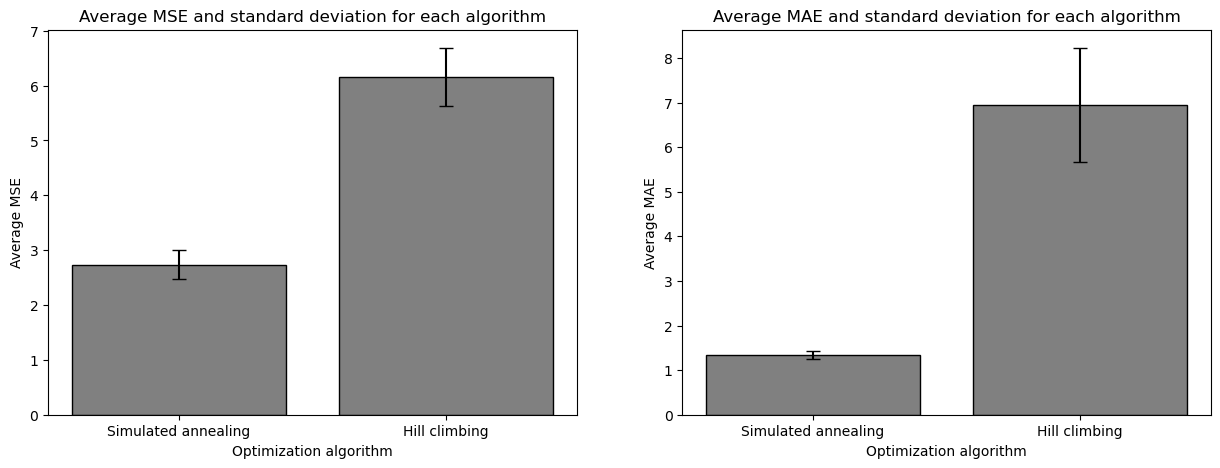

In [237]:
##PLOTTING

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


x = ["Simulated annealing", "Hill climbing"]
mse_list = [mean_mse_annealing,mean_mse_hill_climbing] #Stores the mean mse for both algorithms
std_mse_list = [std_mse_annealing,std_mse_hill_climbing]

mae_list = [mean_mae_annealing,mean_mae_hill_climbing] #Stores the mean mae for both algorithms
std_mae_list = [std_mae_annealing,std_mae_hill_climbing]

axes[0].bar(x, mse_list, yerr = std_mse_list,color = "grey",ec = "black", ecolor = "black",capsize = 5)
axes[1].bar(x, mae_list, yerr = std_mae_list,color = "grey",ec = "black", ecolor = "black",capsize = 5)



axes[0].set_xlabel("Optimization algorithm")
axes[1].set_xlabel("Optimization algorithm")

axes[0].set_ylabel("Average MSE")
axes[1].set_ylabel("Average MAE")

axes[0].set_title("Average MSE and standard deviation for each algorithm")
axes[1].set_title("Average MAE and standard deviation for each algorithm")



#plt.bar(x, mse_list, yerr = std_list,color = "grey",ec = "black", ecolor = "black",capsize = 5)
#plt.title("Bar plot comparing the means and errors of the MSE")
#plt.ylabel("MSE")
#plt.xlabel("Optimization algorithm")